# Vibrational frequencies

## Manual calculation of vibrational frequency

The principle idea in calculating vibrational frequencies is that we consider a **molecular** system as ****masses** connected by **springs**. If the springs are Hookean, e.g. the force is proportional to the displacement, then we can readily solve the equations of motion and find that the *vibrational frequencies* are related to the *force constants* and the *masses of the atoms*. 

For example, in a simple molecule like CO where there is only one spring, the frequency is:

$\nu = \frac{1}{2\pi} \sqrt{k/\mu}$ where $\frac{1}{\mu} = \frac{1}{m_C} + \frac{1}{m_O}$ and $k$ in the spring constant.

We will compute the value of $k$ from DFT calculations as follows $k = \frac{\partial^2 E}{\partial x^2}$ at the equilibrium bond length. We actually already have the data to do this from [Manual determination of a bond length](./2_4_mol_geo_optimization.html#manual-determination-of-a-bond-length). We only need to fit an equation to the energy vs. bond-length data, find the minimum energy bond-length, and then evaluate the second derivative of the fitted function at the minimum. 

We will use a cubic polynomial for demonstration here. Polynomials are numerically convenient because they are easy to fit, and it is trivial to get the roots and derivatives of the polynomials, as well as to evaluate them at other points using `numpy.polyfit`, `numpy.polyder`, and `numpy.polyval`.

Get energy from previous calculations

In [1]:
from gpaw import restart

bond_lengths = [1.05, 1.1, 1.15, 1.2, 1.25]
energies = []
for d in bond_lengths:
    mol, calc = restart('molecules/simple_CO_d{}.gpw'.format(d))
    energies.append(mol.get_potential_energy())

Fitting

In [5]:
import numpy as np
from ase.units import kg, J, m
from ase.data import atomic_masses

## fit the data
pars = np.polyfit(bond_lengths, energies, 3)  # reture coeffs of polynomial  [deg, deg-1, … 0]
xfit = np.linspace(1.05, 1.25)
efit = np.polyval(pars, xfit)

### Find d_min
# first derivative
# find where the minimum is. chose the second one because it is the minimum we need.
droots = np.roots(dpars)    # 2 roots for degree=3

# second derivative
ddpars = np.polyder(dpars)
d_min = droots[np.polyval(ddpars, droots) > 0]

# curvature at minimum = force constant in SI units
k = np.polyval(ddpars, d_min) / (J / m**2)

# mu, reduced mass
C_mass = atomic_masses[6] / kg
O_mass = atomic_masses[8] / kg

mu = 1.0 / (1.0 / C_mass + 1.0 / O_mass)

frequency = 1. / (2. * np.pi) * np.sqrt(k / mu)
print('The CO vibrational frequency is {0} Hz'.format(*frequency))
print('The CO vibrational frequency is {0[0]} cm^{{-1}}'.format(frequency / 3e10))

The CO vibrational frequency is 64876008880843.62 Hz
The CO vibrational frequency is 2162.533629361454 cm^{-1}


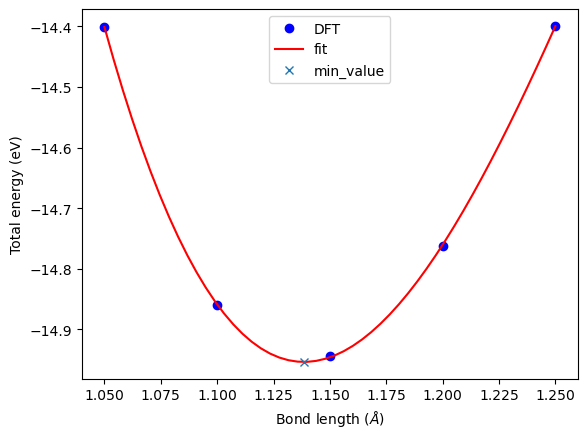

In [12]:
import matplotlib.pyplot as plt

efit_min = np.polyval(pars, d_min)

plt.plot(bond_lengths, energies, 'bo', label='DFT')
plt.plot(xfit, efit, 'r-', label='fit')
plt.plot(d_min, efit_min, 'x', label='min_value')
plt.xlabel('Bond length ($\AA$)')
plt.ylabel('Total energy (eV)')
plt.legend(loc='upper center')
plt.show()

This result is in good agreement with [experiment](https://webbook.nist.gov/cgi/cbook.cgi?ID=C630080&Units=SI&Type=IR-SPEC&Index=0#IR-SPEC). The procedure described above is basically *how many vibrational calculations* are performed. With more atoms, you have to determine a force constant matrix and diagonalize it. For more details, see {cite:p}`wilson1955`. 

In practice, we usually allow a packaged code to automate this, which we cover in [Automated vibrational calculations](./2_5_mol_vibration.html#Automated vibrational calculations).

We now consider how much energy is in this vibration. This is commonly called **zero-point energy (ZPE)** and it is defined as $EZPE=\frac{1}{2}h\nu$ for a single mode, and $h$ is Planck's constant $(4.135667516e-15 eV/s)$.


In [8]:
c = 3e10             # speed of light cm/s
h = 4.135667516e-15  # eV*s

nu = 2143.6076625*c  # 1/s

E_zpe = 0.5*h*nu

print('E_ZPE = {0:1.3f} eV'.format(E_zpe))

E_ZPE = 0.133 eV


This is a reasonable amount of energy! Zero-point energy increases with increasing vibrational frequency, and tends to be very important for small atoms.

A final note is that this analysis is in the **"harmonic approximation"**. The frequency equation is the solution to a harmonic oscillator. If the spring is non-linear, then there are anharmonic effects that may become important, especially at higher temperatures.

## Automated vibrational calculations

GPAW have many manual for calculations of [vibration properties](https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/vibrational/vibrational.html)

The calculation described here is dapted from [GPAW manual](https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/vibrational/vibrations/vibrations.html)

Density functional theory can be used to calculate vibrational frequencies of molecules, e.g. either in the gas phase or on a surface. These results can be compared to experimental output, e.g. from IR-spectroscopy. In this example we will calculate the vibrational frequencies for a water molecule.
- For a simple molecule, like `CO`, there is only one stretching mode. How would you calculate the vibrational frequency of this mode?
- For a general molecule with N atoms, how many modes are there? How many of them are vibrational modes? How would you do a calculation for the vibrational modes? Describe in detail which steps have to be performed.

Calulate vibration with module `ase.vibrations`. You can specify:
- the number of displacements with `free`, default number of displacements is 2. 
- the size of the displacement with `delta`, default is 0.01

In [18]:
from math import cos, sin, pi

from ase import Atoms
from ase.optimize import QuasiNewton
from ase.vibrations import Vibrations
from gpaw import GPAW

# Water molecule:
d = 0.9575
t = pi / 180 * 104.51

H2O = Atoms('H2O',
            positions=[(0, 0, 0),
                       (d, 0, 0),
                       (d * cos(t), d * sin(t), 0)])
H2O.center(vacuum=3.5)

## GPAW calculator
calc = GPAW(mode='lcao', basis='dzp', h=0.2, txt='molecules/h2o.txt')
H2O.calc = calc

## Minimize
QuasiNewton(H2O).run(fmax=0.05)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 16:20:50       -9.313801*       5.8622
BFGSLineSearch:    1[  1] 16:20:51      -10.846138*       7.7659
BFGSLineSearch:    2[  2] 16:20:51      -12.601781*       7.3392
BFGSLineSearch:    3[  3] 16:20:52      -13.334419*       4.4396
BFGSLineSearch:    4[  5] 16:20:54      -13.505857*       2.8911
BFGSLineSearch:    5[  7] 16:20:55      -13.704775*       1.0850
BFGSLineSearch:    6[  9] 16:20:56      -13.719613*       0.1253
BFGSLineSearch:    7[ 10] 16:20:57      -13.719917*       0.0452


True

In [19]:
"""Calculate the vibrational modes of a H2O molecule."""

# Create vibration calculator
vib = Vibrations(H2O, delta=0.01, nfree=2)
# vib.symmetry='off'
vib.run()
vib.summary(method='frederiksen')

# Make trajectory files to visualize normal modes:
for mode in range(9):
    vib.write_mode(mode)

RuntimeError: Broken symmetry!


### Zero-point energy for multiple modes